# Training a Convolutional Neural Network for Kidney Stones Object Detection

In [9]:
%pip install tabulate opencv-python matplotlib

  Using cached matplotlib-3.10.1-cp310-cp310-win_amd64.whl (8.1 MB)
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl (71 kB)
  Using cached fonttools-4.56.0-cp310-cp310-win_amd64.whl (2.2 MB)
  Using cached pillow-11.1.0-cp310-cp310-win_amd64.whl (2.6 MB)
  Using cached contourpy-1.3.1-cp310-cp310-win_amd64.whl (218 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\projects\ebook_object_detection\chapters\kidney_stones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
from tabulate import tabulate

# Define the path to the data directory
data_dir = 'data'
sets = ['train', 'test', 'valid']

# Initialize a summary list to store the data for tabulation
data_summary = []

# Function to get the total file size and count of files in a directory
def get_data_size(directory):
    total_size = 0
    total_files = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        total_files += len(filenames)
        total_size += sum(os.path.getsize(os.path.join(dirpath, f)) for f in filenames)
    return total_files, total_size

# Gather the data size information for each dataset
for data_set in sets:
    images_dir = os.path.join(data_dir, data_set, 'images')
    labels_dir = os.path.join(data_dir, data_set, 'labels')

    # Get the number of image files and their total size
    num_image_files, image_total_size = get_data_size(images_dir)
    
    # Get the number of label files and their total size
    num_label_files, label_total_size = get_data_size(labels_dir)
    
    # Add the data summary for the current dataset
    data_summary.append([
        data_set.capitalize(),
        num_image_files,
        num_label_files,
        f"{image_total_size / (1024 * 1024):.2f} MB",  # Convert bytes to MB
        f"{label_total_size / (1024 * 1024):.2f} MB"  # Convert bytes to MB
    ])

# Define the table headers
headers = ["Dataset", "Number of Images", "Number of Labels", "Total Image Size", "Total Label Size"]

# Print the table
print(tabulate(data_summary, headers=headers, tablefmt="grid"))

+-----------+--------------------+--------------------+--------------------+--------------------+
| Dataset   |   Number of Images |   Number of Labels | Total Image Size   | Total Label Size   |
+===========+====================+====================+====================+====================+
| Train     |               1054 |               1054 | 16.43 MB           | 0.13 MB            |
+-----------+--------------------+--------------------+--------------------+--------------------+
| Test      |                123 |                123 | 2.03 MB            | 0.01 MB            |
+-----------+--------------------+--------------------+--------------------+--------------------+
| Valid     |                123 |                123 | 2.05 MB            | 0.02 MB            |
+-----------+--------------------+--------------------+--------------------+--------------------+


In [3]:
import cv2
import os
import random
import matplotlib.pyplot as plt

# Function to visualize bounding boxes on an image
def visualize_bounding_boxes(image_path, label_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image from BGR to RGB (since OpenCV loads images in BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Read the annotation file
    with open(label_path, 'r') as file:
        lines = file.readlines()
    
    # Iterate through each annotation line
    for line in lines:
        # Parse the annotation line
        parts = line.strip().split()
        class_id = int(parts[0])
        center_x = float(parts[1])
        center_y = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])

        # Convert normalized coordinates to actual pixel values
        img_height, img_width, _ = image.shape
        xmin = int((center_x - width / 2) * img_width)
        ymin = int((center_y - height / 2) * img_height)
        xmax = int((center_x + width / 2) * img_width)
        ymax = int((center_y + height / 2) * img_height)

        # Draw the bounding box (class_id can be used to color or label the box)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Green bounding box
    
    return image

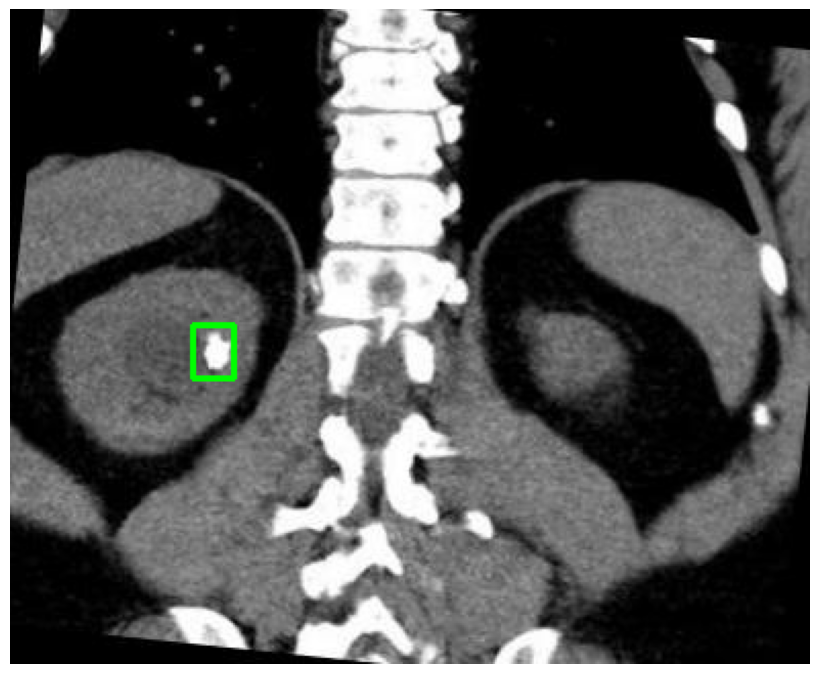

In [6]:
# Get all image file names from the train/images directory
image_dir = 'data/train/images'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Randomly select one image
random_image_file = random.choice(image_files)

# Construct the corresponding label file path
label_file = random_image_file.replace('.jpg', '.txt')  # Assuming the label file has the same name as the image

# Define the full paths
image_path = os.path.join(image_dir, random_image_file)
label_path = os.path.join('data/train/labels', label_file)

# Visualize the bounding boxes on the selected random image
image_with_bboxes = visualize_bounding_boxes(image_path, label_path)

# Display the image with bounding boxes on a dark background, without any margins or borders
plt.figure(figsize=(8, 8))
plt.imshow(image_with_bboxes)
plt.axis('off')  # Hide axis
plt.gca().set_facecolor('black')  # Set background color to dark
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove extra margins
plt.savefig("sample_image.png", bbox_inches='tight', pad_inches=0)  # Save without extra padding
plt.show()